In [1]:
from matplotlib import rcParams
from warnings import filterwarnings
filterwarnings("ignore")
rcParams["font.size"] = "12"

## Load Data

Download data from gdrive. Original data can be founded [here](https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification) (kaggle competition)

In [2]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd
import pandas as pd
from tqdm import tqdm

In [3]:
# donwload from gdrive
gdd.download_file_from_google_drive(file_id='1cjIH-BVLLAi_0qfx2E7DtJjl6G4opQla',
                                    dest_path='./data/data.csv')

In [4]:
# read file (100'000 examples for faster computing)
df = pd.read_csv('./data/data.csv')[['comment_text', 'toxic']].sample(100000, random_state=42)
df.shape

(100000, 2)

In [5]:
# display data
df.head()

,comment_text,toxic
170259,:You might like to consider that I don't give ...,1
92211,"What the heck are you talking about? I ask, my...",0
102203,Uncle Tom House Niggers,1
153827,"Well, just because you hate the word doesn't m...",0
97484,source: Places named Scotland,0


In [6]:
# target distribution
df['toxic'].value_counts()

0    90462
1     9538
Name: toxic, dtype: int64

## Preprocessing

Preprocessing include: lowercase, tokenization, punctuation, stopwords, len(words) from 3 to 9, lemmatization

In [7]:
import numpy as np
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from string import punctuation
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maksi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
# stopwords & punctuation
stopwords = nltk.corpus.stopwords.words('english')
punctuation = punctuation.replace("!", "")

In [10]:
%%time
# preprocessing
def remove_punctuations(text):
    for punct in punctuation:
        text = text.replace(punct, '')
    return text

# lowercase + \n to " "
df['comment_text'] = df['comment_text'].str.lower().str.replace("\n", " ")
# tokenize
df['comment_text'] = df['comment_text'].apply(nltk.word_tokenize)
# punctuation
df['comment_text'] = df['comment_text'].apply(lambda x: " ".join(x)).apply(remove_punctuations).str.split()
# stopwords
df['comment_text'] = df['comment_text'].apply(lambda x: [i for i in x if i not in stopwords])
 # len(word) > 2 && len(word) < 2
df['comment_text'] = df['comment_text'].apply(lambda x: [i for i in x if len(i) > 2 or len(i) < 10])
# lemmatization
df['comment_text'] = df['comment_text'].apply(lambda x: [nltk.stem.WordNetLemmatizer().lemmatize(i) for i in x]) 

Wall time: 1min 19s


In [11]:
# remove empty texts
not_empty_indexes = df[['comment_text']][df['comment_text'].apply(lambda x: len(x)) != 0].index
df = df.loc[not_empty_indexes]
df.shape

(99972, 2)

In [12]:
# display data after preprocessing
df.head()

,comment_text,toxic
170259,"[might, like, consider, nt, give, shit, think]",1
92211,"[heck, talking, ask, good, chum, question, unc...",0
102203,"[uncle, tom, house, nigger]",1
153827,"[well, hate, word, nt, mean, mentioning, wp, v...",0
97484,"[source, place, named, scotland]",0


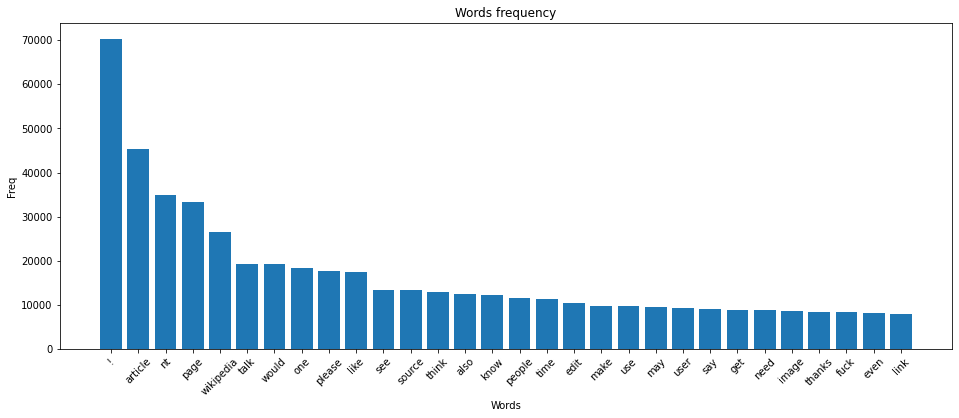

In [13]:
# Words Frequency visualizaion
wordfreq = nltk.FreqDist([j for i in df['comment_text'].tolist() for j in i])
wordfreq = {k: v for k, v in sorted(dict(wordfreq).items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=(16, 6))
plt.bar(list(wordfreq.keys())[:30], list(wordfreq.values())[:30])
plt.title('Words frequency')
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel('Freq')
plt.show()

In [14]:
# ! sign by class (check does it make sense) => yes, that make sense to left '!' in text
toxic_1 = df.loc[df['toxic']==1, 'comment_text'].apply(lambda x: "!" in x).sum() / df.loc[df['toxic']==1].size
toxic_0 = df.loc[df['toxic']==0, 'comment_text'].apply(lambda x: "!" in x).sum() / df.loc[df['toxic']==0].size
print(f"Toxic: {round(toxic_1, 3)}, Not Toxic: {round(toxic_0, 3)}")

Toxic: 0.129, Not Toxic: 0.066


In [15]:
# split
X_train, X_test, y_train, y_test = train_test_split(df[['comment_text']], df['toxic'], test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)
X_train.shape, X_val.shape, X_test.shape

((79977, 1), (9998, 1), (9997, 1))

## Classical ML

Classical ML approaches include: 1) Model by WordsFrequences; 2) Logistic Regression on tf-idf; 3) Random Forest on tf-idf.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from umap import UMAP
import seaborn as sns
from collections import Counter

### Model by WordFreq

Calculate how often word occurs in each class normalized on class probability

In [17]:
# indexes
toxic_indexes = y_train[y_train == 1].index
not_toxic_indexes = y_train[y_train == 0].index
# sentences
sentences = X_train['comment_text'].to_list()
sentences_toxic = X_train.loc[toxic_indexes]['comment_text'].to_list()
sentences_not_toxic = X_train.loc[not_toxic_indexes]['comment_text'].to_list()
# words
words = [w for sent in sentences for w in sent]
words_toxic = [w for sent in sentences_toxic for w in sent]
words_not_toxic = [w for sent in sentences_not_toxic for w in sent]

In [18]:
# calculate probas: add 1 to each word for toxic and not toxic because we need fill nans by 1 (something like Laplace smoothing)
class_freq = y_train.value_counts(normalize=True).to_dict()
df_words = pd.DataFrame(dict(Counter(words)), index=['word']).T
df_toxic_words = (pd.DataFrame(dict(Counter(words_toxic)), index=['word_toxic']).T + 1) / class_freq[1]
df_not_toxic_words = (pd.DataFrame(dict(Counter(words_not_toxic)), index=['word_not_toxic']).T + 1) / class_freq[0]
freq_df = pd.concat([df_words, df_toxic_words, df_not_toxic_words], axis=1).fillna(1)
freq_df['toxic_prob'] = freq_df['word_toxic'] / freq_df['word_not_toxic']
freq_df.head()

,word,word_toxic,word_not_toxic,toxic_prob
gene,103,221.396915,92.802531,2.385678
hunt,73,94.884392,72.916274,1.301279
page,27013,11702.408384,28619.637593,0.408894
sorry,2165,1528.692987,2233.889489,0.684319
unintentional,22,1.000000,25.410217,0.039354


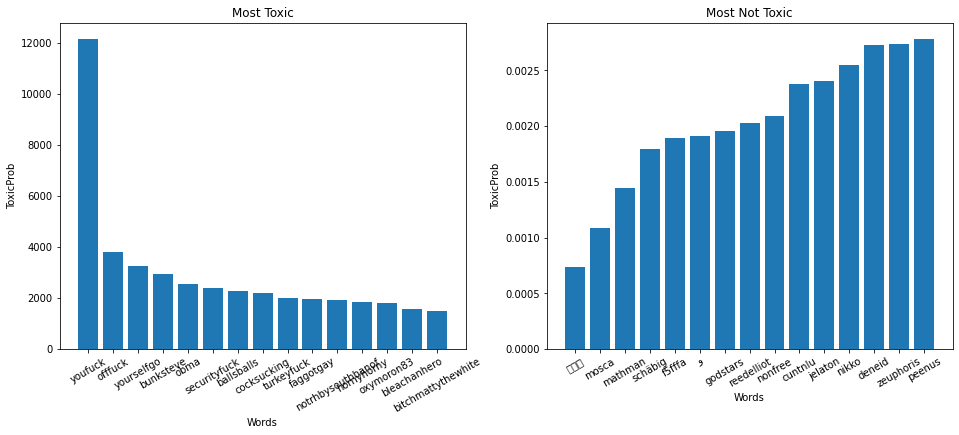

In [19]:
# viz
most_toxic = freq_df.sort_values("toxic_prob", ascending=False)[:15]
most_not_toxic = freq_df.sort_values("toxic_prob", ascending=True)[:15]

fig, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].bar(most_toxic.index, most_toxic['toxic_prob'])
ax[0].tick_params(axis='x', rotation=30)
ax[0].set_title("Most Toxic")
ax[0].set_xlabel("Words")
ax[0].set_ylabel("ToxicProb")
ax[1].bar(most_not_toxic.index, most_not_toxic['toxic_prob'])
ax[1].tick_params(axis='x', rotation=30)
ax[1].set_title("Most Not Toxic")
ax[1].set_xlabel("Words")
ax[1].set_ylabel("ToxicProb")
plt.show()

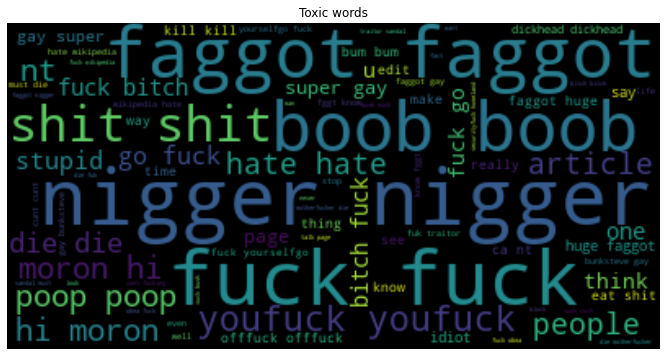

In [20]:
# WordCloud Toxic
wordcloud = WordCloud().generate(" ".join(words_toxic))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Toxic words")
plt.axis("off")
plt.show()

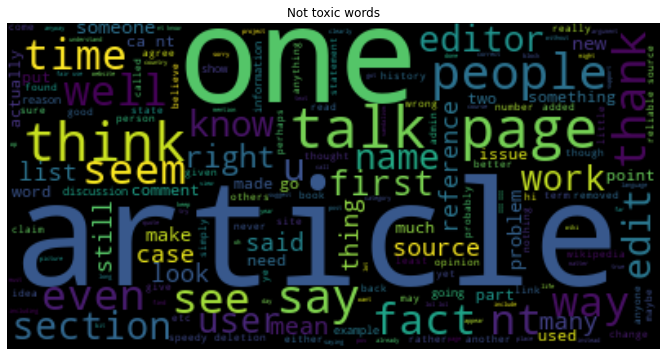

In [21]:
# WordCloud NotToxic
wordcloud = WordCloud().generate(" ".join(words_not_toxic))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Not toxic words")
plt.axis("off")
plt.show()

In [22]:
# calculate probas: sum(words) - len(words), because 
w2prob = freq_df['toxic_prob'].to_dict()
train_pred = X_train['comment_text'].apply(lambda x: sum([w2prob[i] for i in x if i in w2prob]) - len(x)) > 0
test_pred = X_test['comment_text'].apply(lambda x: sum([w2prob[i] for i in x if i in w2prob]) - len(x)) > 0
train_score = roc_auc_score(y_train, train_pred)
test_score = roc_auc_score(y_test, test_pred)
print(f"TrainScore: {round(train_score, 3)}, TestScore: {round(test_score, 3)}")

TrainScore: 0.888, TestScore: 0.862


### Logistic regression on tf-idf

Simple Logistic Regression with tf-idf

In [23]:
# tfidf
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train['comment_text'].apply(" ".join))
X_test_tfidf = vectorizer.transform(X_test['comment_text'].apply(" ".join))
X_val_tfidf = vectorizer.transform(X_val['comment_text'].apply(" ".join))

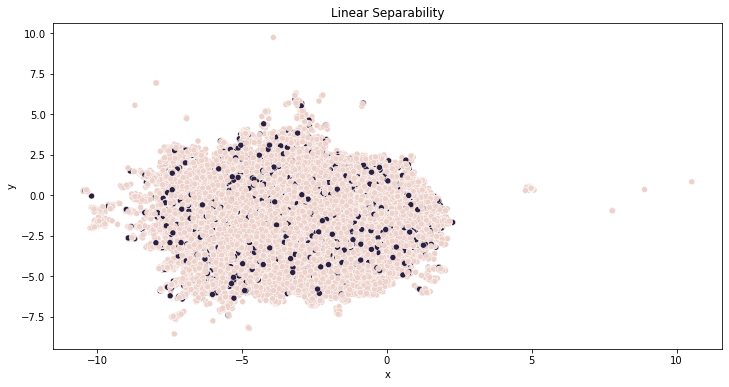

Wall time: 4min 19s


In [24]:
%%time
# tfidf viz => there are no linear separability (after umap)
embedding = UMAP(n_neighbors=30, min_dist=0.5, random_state=42, metric='cosine').fit_transform(X_train_tfidf)
embedding = pd.DataFrame(embedding, columns=['x', 'y'])

plt.figure(figsize=(12,6))
sns.scatterplot(data=embedding, x='x', y='y', hue=df['toxic'], legend=False)
plt.title("Linear Separability")
plt.show()

In [25]:
# grid search
best_score = -np.inf
best_penalty = None
class_weight = X_train.size / (2 * np.bincount(y_train)) # Size / (num_classes * [size_class_0, size_class_1])
class_weight = {0:class_weight[0], 1:class_weight[1]} # class_weight to dict

for C in tqdm(np.arange(0.1, 3, 0.1)):
  model = LogisticRegression(C=C, class_weight=class_weight, max_iter=300)
  model.fit(X_train_tfidf, y_train)
  score = roc_auc_score(y_val, model.predict_proba(X_val_tfidf)[:, 1])
  if score > best_score:
    best_score = score
    best_penalty = C

print(f"\nBest Score: {round(best_score, 2)}, Best Penalty: {best_penalty}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:49<00:00,  3.76s/it]


Best Score: 0.97, Best Penalty: 1.2000000000000002


In [26]:
# model&scores
model = LogisticRegression(C=best_penalty, class_weight=class_weight, max_iter=300)
model.fit(X_train_tfidf, y_train)

train_score = roc_auc_score(y_train, model.predict_proba(X_train_tfidf)[:, 1])
test_score = roc_auc_score(y_test, model.predict_proba(X_test_tfidf)[:, 1])
print(f"TrainScore: {round(train_score, 3)}, TestScore: {round(test_score, 3)}")

TrainScore: 0.991, TestScore: 0.959


### RandomForest

Random Forest with optuna

In [27]:
from sklearn.ensemble import RandomForestClassifier
import optuna

In [28]:
class_weight = X_train.size / (2 * np.bincount(y_train))
class_weight = {0:class_weight[0], 1:class_weight[1]}
    
def objective(trial):
    # params
    n_estimators = int(trial.suggest_loguniform('n_estimators', 50, 200))
    max_depth = int(trial.suggest_loguniform('max_depth', 2, 32))
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight=class_weight, n_jobs=-1,
                                   random_state=42)
    model.fit(X_train_tfidf, y_train)
    score = roc_auc_score(y_val, model.predict_proba(X_val_tfidf)[:, 1])
    
    return score

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100,)

[I 2021-10-11 09:23:09,903] A new study created in memory with name: no-name-fba48aca-d01d-442e-853a-81ff9e92e58d
[I 2021-10-11 09:23:12,048] Trial 0 finished with value: 0.8817161825757815 and parameters: {'n_estimators': 95.40251923198038, 'max_depth': 23.934300231035742}. Best is trial 0 with value: 0.8817161825757815.
[I 2021-10-11 09:23:13,332] Trial 1 finished with value: 0.8881982988358346 and parameters: {'n_estimators': 174.1937861345111, 'max_depth': 9.453887756523901}. Best is trial 1 with value: 0.8881982988358346.
[I 2021-10-11 09:23:13,907] Trial 2 finished with value: 0.8623269638670784 and parameters: {'n_estimators': 80.82010414008687, 'max_depth': 7.108718785909642}. Best is trial 1 with value: 0.8881982988358346.
[I 2021-10-11 09:23:16,308] Trial 3 finished with value: 0.8892593795888925 and parameters: {'n_estimators': 125.33446873466114, 'max_depth': 21.345818704397995}. Best is trial 3 with value: 0.8892593795888925.
[I 2021-10-11 09:23:18,088] Trial 4 finished wi

[I 2021-10-11 09:24:13,935] Trial 36 finished with value: 0.8911458646415666 and parameters: {'n_estimators': 199.9827445767407, 'max_depth': 17.06584136717653}. Best is trial 22 with value: 0.8916968299131623.
[I 2021-10-11 09:24:15,321] Trial 37 finished with value: 0.8851171512346296 and parameters: {'n_estimators': 196.76679637559968, 'max_depth': 8.719396858038863}. Best is trial 22 with value: 0.8916968299131623.
[I 2021-10-11 09:24:17,691] Trial 38 finished with value: 0.8904947130233662 and parameters: {'n_estimators': 162.31378129223828, 'max_depth': 17.84176517155323}. Best is trial 22 with value: 0.8916968299131623.
[I 2021-10-11 09:24:21,795] Trial 39 finished with value: 0.8874817875534208 and parameters: {'n_estimators': 183.48437778884713, 'max_depth': 23.947599637745892}. Best is trial 22 with value: 0.8916968299131623.
[I 2021-10-11 09:24:24,410] Trial 40 finished with value: 0.8915639040997207 and parameters: {'n_estimators': 199.33099219715072, 'max_depth': 16.450109

[I 2021-10-11 09:25:36,943] Trial 73 finished with value: 0.8893180005286021 and parameters: {'n_estimators': 156.1226722740621, 'max_depth': 18.97143351533478}. Best is trial 22 with value: 0.8916968299131623.
[I 2021-10-11 09:25:38,583] Trial 74 finished with value: 0.8888706804179584 and parameters: {'n_estimators': 164.85124031337068, 'max_depth': 12.81263002916351}. Best is trial 22 with value: 0.8916968299131623.
[I 2021-10-11 09:25:40,724] Trial 75 finished with value: 0.8893812133425313 and parameters: {'n_estimators': 175.37926142550205, 'max_depth': 15.010619697718008}. Best is trial 22 with value: 0.8916968299131623.
[I 2021-10-11 09:25:43,323] Trial 76 finished with value: 0.8908658795836446 and parameters: {'n_estimators': 191.4840119183098, 'max_depth': 16.798581792428664}. Best is trial 22 with value: 0.8916968299131623.
[I 2021-10-11 09:25:46,849] Trial 77 finished with value: 0.8881081907586206 and parameters: {'n_estimators': 193.1530383551547, 'max_depth': 20.7144088

In [29]:
# score
model = RandomForestClassifier(n_estimators=int(study.best_params['n_estimators']), max_depth=int(study.best_params['max_depth']),
                               class_weight=class_weight, n_jobs=-1, random_state=42)
model.fit(X_train_tfidf, y_train)

train_score = roc_auc_score(y_train, model.predict_proba(X_train_tfidf)[:, 1])
test_score = roc_auc_score(y_test, model.predict_proba(X_test_tfidf)[:, 1])
print(f"TrainScore: {round(train_score, 3)}, TestScore: {round(test_score, 3)}")

TrainScore: 0.931, TestScore: 0.878


## NN

Linear and LSTM models, architectures below. Main idea: lets combine embeddings for glove and fasttext

In [30]:
import gensim.downloader as api
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.tensorboard import SummaryWriter
import shutil

In [31]:
%%time
# load models
glove = api.load("glove-wiki-gigaword-200")

Wall time: 47.9 s


In [32]:
%%time
# load models
fasttext = api.load("fasttext-wiki-news-subwords-300")

Wall time: 2min 53s


In [33]:
%%time
# copy for preprocessing
df_glove = df.copy()
df_fasttext = df.copy()
# convert word to vector
df_glove['comment_text'] = df_glove['comment_text'].apply(lambda x: [word for word in x if word in glove.key_to_index])
df_fasttext['comment_text'] = df_fasttext['comment_text'].apply(lambda x: [word for word in x if word in fasttext.key_to_index])
# padding
seq_len = 65
# Glove
df_glove['comment_text'] = df_glove['comment_text'].apply(lambda x: [x, min(seq_len, len(x))])
df_glove['comment_text'] = df_glove['comment_text'].apply(lambda x: [np.pad(x[0][:seq_len], (0, max(0, seq_len - len(x[0]))), constant_values=(0, 0)), x[1]])
# FastText
df_fasttext['comment_text'] = df_fasttext['comment_text'].apply(lambda x: [x, min(seq_len, len(x))])
df_fasttext['comment_text'] = df_fasttext['comment_text'].apply(lambda x: [np.pad(x[0][:seq_len], (0, max(0, seq_len - len(x[0]))), constant_values=(0, 0)), x[1]])

Wall time: 9.12 s


In [34]:
# get vocab
vocab_glove = set([word for doc in df_glove['comment_text'].apply(lambda x: x[0]).values for word in doc])
vocab_fasttext = set([word for doc in df_fasttext['comment_text'].apply(lambda x: x[0]).values for word in doc])

# word2idx & idx2word
word2idx_glove = {j:i for i, j in enumerate(vocab_glove)}
idx2word_glove = {i:j for i, j in enumerate(vocab_glove)}
word2idx_fasttext = {j:i for i, j in enumerate(vocab_fasttext)}
idx2word_fasttext = {i:j for i, j in enumerate(vocab_fasttext)}

In [35]:
# convert word to indexes
df_glove['comment_text'] = df_glove['comment_text'].apply(lambda x: [[word2idx_glove[word] for word in x[0]], x[1]])
df_fasttext['comment_text'] = df_fasttext['comment_text'].apply(lambda x: [[word2idx_fasttext[word] for word in x[0]], x[1]])

In [36]:
# split glove
X_train_glove = df_glove.loc[X_train.index, ['comment_text']]
X_test_glove = df_glove.loc[X_test.index, ['comment_text']]
X_val_glove = df_glove.loc[X_val.index, ['comment_text']]
print(X_train_glove.shape, X_test_glove.shape, X_val_glove.shape)

# split fasttext
X_train_fasttext = df_fasttext.loc[X_train.index, ['comment_text']]
X_test_fasttext = df_fasttext.loc[X_test.index, ['comment_text']]
X_val_fasttext = df_fasttext.loc[X_val.index, ['comment_text']]
print(X_train_fasttext.shape, X_test_fasttext.shape, X_val_fasttext.shape)

# get labels
y_train_nn = df_glove.loc[y_train.index, 'toxic']
y_test_nn = df_glove.loc[y_test.index, 'toxic']
y_val_nn = df_glove.loc[y_val.index, 'toxic']

(79977, 1) (9997, 1) (9998, 1)
(79977, 1) (9997, 1) (9998, 1)


In [37]:
# Dataset
class TextDataset(Dataset):
  def __init__(self, X_glove, X_fasttext, Y):
    self.X_glove = X_glove
    self.X_fasttext = X_fasttext
    self.y = Y
    
    self.X_glove.index = range(len(self.X_glove))
    self.X_fasttext.index = range(len(self.X_fasttext))
    self.y.index = range(len(self.y))
        
  def __len__(self):
    return len(self.y)
    
  def __getitem__(self, idx):
    x_glove, x_fasttext = torch.LongTensor(self.X_glove.loc[idx][0][0]), torch.LongTensor(self.X_fasttext.loc[idx][0][0])
    y_value = self.y[idx] # y batch
    x_len = self.X_glove.loc[idx][0][1] # len(x) P.S. see model
    return x_glove, x_fasttext, y_value, x_len

In [38]:
# create datasets
dataset_train = TextDataset(X_train_glove, X_train_fasttext, torch.FloatTensor(y_train_nn.values))
dataset_test = TextDataset(X_test_glove, X_test_fasttext, torch.FloatTensor(y_test_nn.values))
dataset_val = TextDataset(X_val_glove, X_val_fasttext, torch.FloatTensor(y_val_nn.values))

# create dataloaders
dataloader_train = DataLoader(dataset_train, batch_size=512, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=512, shuffle=False)
dataloader_val = DataLoader(dataset_val, batch_size=512, shuffle=False)

In [39]:
# create weights matrix
"""
Matrices with weights for nn.Embedding
"""
vector_len_glove = 200 # length for glove vector
vector_len_fasttext = 300 # length for fasttext vector
matrix_len_glove = len(vocab_glove)
matrix_len_fasttext = len(vocab_fasttext)
weights_matrix_glove = np.zeros((matrix_len_glove, vector_len_glove))
weights_matrix_fasttext = np.zeros((matrix_len_fasttext, vector_len_fasttext))

# glove
for i, word in enumerate(vocab_glove):
  if word == 0: # if pad -> init zeros matrix
    weights_matrix_glove[i] = np.zeros(vector_len_glove).astype('float32')
  elif word not in vocab_glove: # if word not in vocab -> init random matrix
    weights_matrix_glove[i] = np.random.normal(size=vector_len_glove).astype('float32')
  else:
    weights_matrix_glove[i] = glove[word].astype('float32')[:vector_len_glove] # else get vector from gensim.glove

# fasttext
for i, word in enumerate(vocab_fasttext):
  if word == 0: # if pad -> init zeros matrix
    weights_matrix_fasttext[i] = np.zeros(vector_len_fasttext).astype('float32')
  elif word not in vocab_fasttext: # if word not in vocab -> init random matrix
    weights_matrix_fasttext[i] = np.random.normal(size=vector_len_fasttext).astype('float32')
  else:
    weights_matrix_fasttext[i] = fasttext[word].astype('float32')[:vector_len_fasttext] # else get vector from gensim.glove

In [40]:
def create_emb_layer(weights_matrix, embed_type="glove", train_embed=False):
  """
  Create embeddings
  """
  if embed_type == "glove":
    num_embeddings, embedding_dim = weights_matrix_glove.shape
    emb_layer = nn.Embedding.from_pretrained(torch.from_numpy(weights_matrix_glove))
    emb_layer.weight.requires_grad = train_embed
  if embed_type == "fasttext":
    num_embeddings, embedding_dim = weights_matrix_fasttext.shape
    emb_layer = nn.Embedding.from_pretrained(torch.from_numpy(weights_matrix_fasttext))
    emb_layer.weight.requires_grad = train_embed

  return emb_layer, num_embeddings, embedding_dim

In [41]:
class ModelLinear(nn.Module):
  def __init__(self, fit_emb_type='both'):
    """
    Architecture: embeddings -> linear_layer -> [optionally torch.cat -> LeakyRELU -> linear1 ->
    LeakyRELU -> linear2 (output) -> sigmoid
    """
    super().__init__()
    self.fit_emb_type = fit_emb_type
    # embed
    self.emb_glove, num_emb_glove, emb_dim_glove = create_emb_layer(weights_matrix_glove, embed_type='glove',
                                                                             train_embed=True) # custom embeddings
    self.emb_fasttext, num_emb_fasttext, emb_dim_fasttext = create_emb_layer(weights_matrix_fasttext, embed_type='fasttext',
                                                                             train_embed=True) # custom embeddings
    # Linear Layers
    self.linear_glove = nn.Linear(65, 128)
    self.linear_fasttext = nn.Linear(65, 128)
    # Classifier
    if fit_emb_type=="both":
        self.linear1 = nn.Linear(128*2, 64)
    else:
        self.linear1 = nn.Linear(128, 64)
    self.linear2 = nn.Linear(64, 1)
    self.relu = nn.LeakyReLU(inplace=True)
    self.sigmoid = nn.Sigmoid()


  def forward(self, x_glove, x_fasttext, l):
    x_glove = self.emb_glove(x_glove).mean(dim=2).float()
    x_fasttext = self.emb_fasttext(x_fasttext).mean(dim=2).float()
    if self.fit_emb_type == 'both':
      x = torch.cat((self.linear_glove(x_glove),
                     self.linear_fasttext(x_fasttext)), axis=1)
    elif self.fit_emb_type == 'glove':
      x = self.linear_glove(x_glove)
    elif self.fit_emb_type == 'fasttext':
      x = self.linear_fasttext(x_fasttext)
    x = self.relu(x)
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)
    out = self.sigmoid(x)

    return out

In [42]:
class ModelLSTM(nn.Module):
  def __init__(self, hidden_size, num_layers, fit_emb_type='both'):
    """
    Architecture: embedding -> lstm -> torch.cat(lstm_out, ht, ct) -> fc1 -> LeakyRelu -> fc2
    """
    super().__init__()
    self.fit_emb_type = fit_emb_type
    # embed
    self.emb_glove, num_emb_glove, emb_dim_glove = create_emb_layer(weights_matrix_glove, embed_type='glove',
                                                                             train_embed=False) # custom embeddings
    self.emb_fasttext, num_emb_fasttext, emb_dim_fasttext = create_emb_layer(weights_matrix_fasttext, embed_type='fasttext',
                                                                             train_embed=False) # custom embeddings
    # LSTM
    self.lstm_glove = nn.LSTM(input_size=emb_dim_glove, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.lstm_fasttext = nn.LSTM(input_size=emb_dim_fasttext, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    # Classifier
    if self.fit_emb_type == 'both':
      self.linear1 = nn.Linear(hidden_size*6, 32)
    else:
      self.linear1 = nn.Linear(hidden_size*3, 32)
    self.linear2 = nn.Linear(32, 1)
    self.relu = nn.LeakyReLU(inplace=True)
    self.sigmoid = nn.Sigmoid()


  def forward(self, x_glove, x_fasttext, l):
    x_glove = self.emb_glove(x_glove)
    x_fasttext = self.emb_fasttext(x_fasttext)
    lstm_out_glove, (ht_glove, ct_glove) = self.lstm_glove(x_glove.float())
    lstm_out_fasttext, (ht_fasttext, ct_fasttext) = self.lstm_fasttext(x_fasttext.float())
    """
    Нам нужен не последний выход из lstm, а тот, который равен длине последовательности 
    (каждый документ имеет размерность 65, но большая часть может быть паддингом).
    Конструкция ниже позволяет его извлечь. Также я объединяю все три выхода,
    вроде это может быть эффективней с точки зрения метрик
    """
    x_input_glove = torch.cat((lstm_out_glove[torch.arange(lstm_out_glove.shape[0]), l-1], ht_glove[-1], ct_glove[-1]), axis=1)
    x_input_fasttext = torch.cat((lstm_out_fasttext[torch.arange(lstm_out_fasttext.shape[0]), l-1], ht_fasttext[-1], ct_fasttext[-1]), axis=1)
    if self.fit_emb_type == 'both':
      x = torch.cat((x_input_glove, x_input_fasttext), axis=1)
    elif self.fit_emb_type == 'glove':
      x = x_input_glove
    elif self.fit_emb_type == 'fasttext':
      x = x_input_fasttext
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)
    out = self.sigmoid(x)

    return out

### Train

In [43]:
# check device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [44]:
def train(model, run_name, model_type, epochs=100, lr=1e-3):
  """
  Train model and return best_model, train and val losses, val score (roc auc)
  """
  writer = SummaryWriter(log_dir="runs/" + run_name)
  # init loss, optimizer, scheduler and running_loss
  criterion = nn.BCELoss(reduction="sum")
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.5)
  # init return things
  loss_epoch_train = []
  loss_epoch_val = []
  score_epoch_val = []
  best_model = model.state_dict()
  best_val_score = 0

  for epoch in range(epochs):
    model.train() # model to train state
    running_loss_train = 0
    running_loss_val = 0
    running_score_val = 0
    for batch, (x_glove, x_fasttext, y, l) in enumerate(dataloader_train):
      x_glove = x_glove.to(device)
      x_fasttext = x_fasttext.to(device)
      y = y.to(device)
      
      y_hat = model(x_glove, x_fasttext, l)
      loss = criterion(y_hat.T[0], y)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss_train += loss 
    # calculate epoch loss
    loss_temp_train = running_loss_train / (dataset_train.__len__())
    loss_epoch_train.append(loss_temp_train.item()) # append average loss by epoch

    # test evaluation
    model.eval()
    running_loss_val = 0
    with torch.no_grad():
      for iter_num, (x_val_glove, x_val_fasttext, y_val, x_len_val) in enumerate(dataloader_val, start=1):
        x_val_glove = x_val_glove.to(device)
        x_val_fasttext = x_val_fasttext.to(device)
        y_val = y_val.to(device)
        y_val_pred = model(x_val_glove, x_val_fasttext, x_len_val)
        loss = criterion(y_val_pred.T[0], y_val)
        val_score = roc_auc_score(y_val.cpu().numpy(), y_val_pred.T[0].cpu().detach().numpy())
        running_loss_val += loss
        running_score_val += val_score
      loss_temp_val = running_loss_val / (dataset_val.__len__()) # for criterion we have reduction=sum, then we can divide it on len(dataset)
      score_temp_val = running_score_val / iter_num # for roc auc we calculate mean score divided by a number of batches    
      loss_epoch_val.append(loss_temp_val.item())
      score_epoch_val.append(score_temp_val)
      scheduler.step(score_temp_val) # scheduler step by roc auc
      # save best model if roc auc on validation dataset improved
      if score_temp_val > best_val_score:
        best_val_score = score_temp_val
        best_model = model.state_dict()


    # print metrics
    if epoch % 10 == 0:
      print({'Epoch': epoch,
             'Loss Train': round(loss_temp_train.item(), 3),
             'Loss Val': round(loss_temp_val.item(), 3),
             'Score Val': round(score_temp_val, 3)})
    
    # update writer
    writer.add_scalar(f'{model_type} Loss/train', loss_temp_train, epoch)
    writer.add_scalar(f'{model_type} Loss/val', loss_temp_val, epoch)
    writer.add_scalar(f'{model_type} RocAuc/val', score_temp_val, epoch)

  return best_model, loss_epoch_train, loss_epoch_val, score_epoch_val

In [45]:
# remove logs
try:
    shutil.rmtree('runs')
except:
    pass

### LSTM Models

In [46]:
%%time
torch.cuda.empty_cache()
model = ModelLSTM(hidden_size=5, num_layers=3, fit_emb_type='glove')
model = model.to(device)
best_model, loss_epoch_train, loss_epoch_val, score_epoch_val = train(model, run_name='glove', model_type="LSTM", epochs=50)

{'Epoch': 0, 'Loss Train': 0.421, 'Loss Val': 0.307, 'Score Val': 0.621}
{'Epoch': 10, 'Loss Train': 0.172, 'Loss Val': 0.173, 'Score Val': 0.926}
{'Epoch': 20, 'Loss Train': 0.161, 'Loss Val': 0.164, 'Score Val': 0.934}
{'Epoch': 30, 'Loss Train': 0.157, 'Loss Val': 0.161, 'Score Val': 0.937}
{'Epoch': 40, 'Loss Train': 0.155, 'Loss Val': 0.16, 'Score Val': 0.938}
Wall time: 16min 23s


In [47]:
%%time
torch.cuda.empty_cache()
model = ModelLSTM(hidden_size=5, num_layers=3, fit_emb_type='fasttext')
model = model.to(device)
best_model, loss_epoch_train, loss_epoch_val, score_epoch_val = train(model, run_name='fasttext', model_type="LSTM", epochs=50)

{'Epoch': 0, 'Loss Train': 0.394, 'Loss Val': 0.307, 'Score Val': 0.641}
{'Epoch': 10, 'Loss Train': 0.148, 'Loss Val': 0.141, 'Score Val': 0.954}
{'Epoch': 20, 'Loss Train': 0.134, 'Loss Val': 0.131, 'Score Val': 0.96}
{'Epoch': 30, 'Loss Train': 0.131, 'Loss Val': 0.131, 'Score Val': 0.961}
{'Epoch': 40, 'Loss Train': 0.13, 'Loss Val': 0.13, 'Score Val': 0.961}
Wall time: 16min 16s


In [48]:
%%time
torch.cuda.empty_cache()
model = ModelLSTM(hidden_size=5, num_layers=3, fit_emb_type='both')
model = model.to(device)
best_model, loss_epoch_train, loss_epoch_val, score_epoch_val = train(model, run_name='both', model_type="LSTM", epochs=50)

{'Epoch': 0, 'Loss Train': 0.355, 'Loss Val': 0.26, 'Score Val': 0.853}
{'Epoch': 10, 'Loss Train': 0.126, 'Loss Val': 0.128, 'Score Val': 0.963}
{'Epoch': 20, 'Loss Train': 0.116, 'Loss Val': 0.122, 'Score Val': 0.967}
{'Epoch': 30, 'Loss Train': 0.114, 'Loss Val': 0.122, 'Score Val': 0.967}
{'Epoch': 40, 'Loss Train': 0.114, 'Loss Val': 0.121, 'Score Val': 0.967}
Wall time: 16min 59s


### Linear models

In [49]:
%%time
torch.cuda.empty_cache()
model = ModelLinear(fit_emb_type='glove')
model = model.to(device)
best_model, loss_epoch_train, loss_epoch_val, score_epoch_val = train(model, run_name='glove', model_type="Linear", epochs=50, lr=1e-4)

{'Epoch': 0, 'Loss Train': 0.641, 'Loss Val': 0.562, 'Score Val': 0.611}
{'Epoch': 10, 'Loss Train': 0.201, 'Loss Val': 0.198, 'Score Val': 0.9}
{'Epoch': 20, 'Loss Train': 0.154, 'Loss Val': 0.169, 'Score Val': 0.925}
{'Epoch': 30, 'Loss Train': 0.148, 'Loss Val': 0.165, 'Score Val': 0.929}
{'Epoch': 40, 'Loss Train': 0.146, 'Loss Val': 0.164, 'Score Val': 0.93}
Wall time: 15min 31s


In [50]:
%%time
torch.cuda.empty_cache()
model = ModelLinear(fit_emb_type='fasttext')
model = model.to(device)
best_model, loss_epoch_train, loss_epoch_val, score_epoch_val = train(model, run_name='fasttext', model_type="Linear", epochs=50, lr=1e-4)

{'Epoch': 0, 'Loss Train': 0.626, 'Loss Val': 0.548, 'Score Val': 0.433}
{'Epoch': 10, 'Loss Train': 0.163, 'Loss Val': 0.169, 'Score Val': 0.927}
{'Epoch': 20, 'Loss Train': 0.13, 'Loss Val': 0.151, 'Score Val': 0.94}
{'Epoch': 30, 'Loss Train': 0.124, 'Loss Val': 0.148, 'Score Val': 0.943}
{'Epoch': 40, 'Loss Train': 0.122, 'Loss Val': 0.148, 'Score Val': 0.943}
Wall time: 15min 49s


In [51]:
%%time
torch.cuda.empty_cache()
model = ModelLinear(fit_emb_type='both')
model = model.to(device)
best_model, loss_epoch_train, loss_epoch_val, score_epoch_val = train(model, run_name='both', model_type="Linear", epochs=50, lr=1e-4)

{'Epoch': 0, 'Loss Train': 0.606, 'Loss Val': 0.464, 'Score Val': 0.501}
{'Epoch': 10, 'Loss Train': 0.145, 'Loss Val': 0.157, 'Score Val': 0.936}
{'Epoch': 20, 'Loss Train': 0.117, 'Loss Val': 0.144, 'Score Val': 0.946}
{'Epoch': 30, 'Loss Train': 0.111, 'Loss Val': 0.142, 'Score Val': 0.948}
{'Epoch': 40, 'Loss Train': 0.11, 'Loss Val': 0.141, 'Score Val': 0.948}
Wall time: 17min 41s
